# ***NLP Project***
### **Description**
Using the *natural language processing*, we will come up with a set of stocks that we want to track. We will connect sentiment analysis scores with average daily returns, and will determine an optimal blend of stocks associated with each emotion for investment opportunities. So we will reproduce analyses provided in the presentation for security returns, as well as historical backtesting.
### **Dataset that we use**
Our dataset has about *1 million rows*, so I think we will have enough data to make our research. The link to our dataset is [Financial Tweets](https://ieee-dataport.org/open-access/stock-market-tweets-data)

### **Setup**

Please upload the next datasets to your Colab session:

  - `tweets_labelled.csv`
  - `tweets_remaining.csv`

### **Installing dependencies**

  - Install `yfinance`

In [1]:
#!pip install yfinance

### **Import necessary Python libraries**

In [156]:
# MAIN

import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
import datetime
import numpy as np
import gensim
import re
import string
import yfinance as yf

# NLTK

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize

# SKLEARN

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder

# KERAS

from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, Dropout, GlobalMaxPooling1D, Conv1D, MaxPooling1D, SpatialDropout1D
from keras.preprocessing import sequence
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras import regularizers, layers
import keras

### **Connect to Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Load all datasets**
The file `tweets_labelled.csv` consists of *5,000* tweets selected using random sampling out of the *943,672* sampled. Out of those *5,000* tweets, *1,300* were manually annotated and reviewed by a second independent annotator. The file `tweets_remaining.csv` contains the remaining *938,672* tweets.

In [4]:
df_labelled = pd.read_csv('/content/drive/MyDrive/datasets/tweets_labelled.csv', sep=';', on_bad_lines='skip')
df_remaining = pd.read_csv('/content/drive/MyDrive/datasets/tweets_remaining.csv', sep=';', on_bad_lines='skip')

### **Dataset cleanup**
Here we drop useless `id` field

In [5]:
df_labelled = df_labelled.drop(['id'], axis=1)
df_remaining = df_remaining.drop(['id'], axis=1)

Let's use tweets with tickers that are already marked with symbol `$`

At first, we will drop rows in `df_labelled`

In [6]:
df_labelled = df_labelled[df_labelled['text'].str.contains(r'\$[A-Za-z]+', regex=True)].reset_index().drop(['index'], axis=1)
df_labelled

,created_at,text,sentiment
0,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
1,2020-06-09 05:23:06+00:00,$863.69 Million in Sales Expected for Spirit A...,positive
2,2020-04-27 00:41:06+00:00,RT @PipsToDollars: Earnings $AMZN $TSLA $MSFT ...,neutral
3,2020-06-06 15:06:34+00:00,How will the future fly for Spirit Air $SAVE ?...,neutral
4,2020-06-14 18:33:57+00:00,Interesting comparison to 2007-09 market of $S...,negative
...,...,...,...
3704,2020-06-04 18:14:57+00:00,"With ad revenues falling, what’s the impact on...",NaN
3705,2020-04-14 02:15:01+00:00,RT @KelvinSCWong: Well another point to add to...,NaN
3706,2020-06-23 14:08:15+00:00,$ITOX working on a contract with a fortune 500...,NaN
3707,2020-07-14 23:18:34+00:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN


Then we will drop rows in `df_remaining`

In [7]:
df_remaining = df_remaining[df_remaining['full_text'].str.contains(r'\$[A-Za-z]+', regex=True)].reset_index().drop(['index'], axis=1)
df_remaining

,created_at,full_text
0,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...
1,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...
2,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...
3,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...
4,2020-04-09 23:57:27+00:00,Pfizer Shares Acquired by Ipswich Investment M...
...,...,...
683007,2020-07-16 00:00:25+00:00,RT @MadMraket: We tend to spend lot of time in...
683008,2020-07-16 00:00:23+00:00,You \n\n$SPX $SPY #ES_F
683009,2020-07-16 00:00:23+00:00,"$KO Coca-Cola #Options #maxpain Chart, Open In..."
683010,2020-07-16 00:00:06+00:00,Here's a dividends watchlist \nfor the 01/04/0...


### **Amount of data**
Let's see how much data left after dataset loading and dataset cleanup

In [8]:
print("Rows of labelled:", len(df_labelled), "\nRows of remaining:", len(df_remaining))

Rows of labelled: 3709 
Rows of remaining: 683012


So after cleanup we have *3709* rows in `df_labelled` and *683012* rows in `df_remaining`

## **Datasets**
Let's take a look on our datasets

In [9]:
df_labelled.head()

,created_at,text,sentiment
0,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
1,2020-06-09 05:23:06+00:00,$863.69 Million in Sales Expected for Spirit A...,positive
2,2020-04-27 00:41:06+00:00,RT @PipsToDollars: Earnings $AMZN $TSLA $MSFT ...,neutral
3,2020-06-06 15:06:34+00:00,How will the future fly for Spirit Air $SAVE ?...,neutral
4,2020-06-14 18:33:57+00:00,Interesting comparison to 2007-09 market of $S...,negative


In [10]:
df_remaining.head()

,created_at,full_text
0,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...
1,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...
2,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...
3,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...
4,2020-04-09 23:57:27+00:00,Pfizer Shares Acquired by Ipswich Investment M...


Let's add tickers column. We will extract tickers from text using regex

In [11]:
tickers = []
for row in df_labelled.values:
  lst = re.findall(r'\$[A-Za-z]+', row[1])
  tickers.append(lst)
  for i in range(len(lst)):
    lst[i] = lst[i].upper()
df_labelled['tickers'] = tickers
df_labelled

,created_at,text,sentiment,tickers
0,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,[$AMD]
1,2020-06-09 05:23:06+00:00,$863.69 Million in Sales Expected for Spirit A...,positive,[$SPR]
2,2020-04-27 00:41:06+00:00,RT @PipsToDollars: Earnings $AMZN $TSLA $MSFT ...,neutral,"[$AMZN, $TSLA, $MSFT, $AAPL, $AMD, $BA, $FB, $..."
3,2020-06-06 15:06:34+00:00,How will the future fly for Spirit Air $SAVE ?...,neutral,"[$SAVE, $FB, $CRM]"
4,2020-06-14 18:33:57+00:00,Interesting comparison to 2007-09 market of $S...,negative,[$SPX]
...,...,...,...,...
3704,2020-06-04 18:14:57+00:00,"With ad revenues falling, what’s the impact on...",NaN,"[$FB, $GOOGL, $TWTR]"
3705,2020-04-14 02:15:01+00:00,RT @KelvinSCWong: Well another point to add to...,NaN,[$SOXX]
3706,2020-06-23 14:08:15+00:00,$ITOX working on a contract with a fortune 500...,NaN,"[$ITOX, $XRP, $BTC, $SPY, $TSLA, $MSFT, $GOOG,..."
3707,2020-07-14 23:18:34+00:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN,[$DIS]


In [12]:
tickers = []
for row in df_remaining.values:
  lst = re.findall(r'\$[A-Za-z]+', row[1])
  tickers.append(lst)
  for i in range(len(lst)):
    lst[i] = lst[i].upper()
df_remaining['tickers'] = tickers
df_remaining

,created_at,full_text,tickers
0,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...,[$SPX]
1,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...,"[$SPX, $SPY]"
2,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...,[$MSFT]
3,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...,"[$GILD, $MO]"
4,2020-04-09 23:57:27+00:00,Pfizer Shares Acquired by Ipswich Investment M...,[$PFE]
...,...,...,...
683007,2020-07-16 00:00:25+00:00,RT @MadMraket: We tend to spend lot of time in...,"[$AAPL, $MSFT, $NFLX, $AMZN]"
683008,2020-07-16 00:00:23+00:00,You \n\n$SPX $SPY #ES_F,"[$SPX, $SPY]"
683009,2020-07-16 00:00:23+00:00,"$KO Coca-Cola #Options #maxpain Chart, Open In...",[$KO]
683010,2020-07-16 00:00:06+00:00,Here's a dividends watchlist \nfor the 01/04/0...,"[$T, $BMO, $ABBV, $VZ, $JPM]"


In [13]:
df_sentiment = df_labelled[df_labelled['sentiment'].notnull()]
df_sentiment

,created_at,text,sentiment,tickers
0,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,[$AMD]
1,2020-06-09 05:23:06+00:00,$863.69 Million in Sales Expected for Spirit A...,positive,[$SPR]
2,2020-04-27 00:41:06+00:00,RT @PipsToDollars: Earnings $AMZN $TSLA $MSFT ...,neutral,"[$AMZN, $TSLA, $MSFT, $AAPL, $AMD, $BA, $FB, $..."
3,2020-06-06 15:06:34+00:00,How will the future fly for Spirit Air $SAVE ?...,neutral,"[$SAVE, $FB, $CRM]"
4,2020-06-14 18:33:57+00:00,Interesting comparison to 2007-09 market of $S...,negative,[$SPX]
...,...,...,...,...
942,2020-07-08 10:46:20+00:00,Q3 2020 EPS Estimates for Ball Co. $BLL Increa...,positive,[$BLL]
943,2020-07-15 11:47:27+00:00,"$UNH - UnitedHealth beats EPS consensus, reite...",neutral,[$UNH]
944,2020-07-01 11:29:10+00:00,RT @MacroCharts: Breadth – expanding last week...,positive,[$SPX]
945,2020-06-19 17:56:57+00:00,$AAPL $QQQ Top may now be in. https://t.co/iNK...,positive,"[$AAPL, $QQQ]"


Looks like we have first *947* rows in `df_labelled` with the text sentiment already found

Let's see how feelings are distributed across all tweets.

<Axes: ylabel='sentiment'>

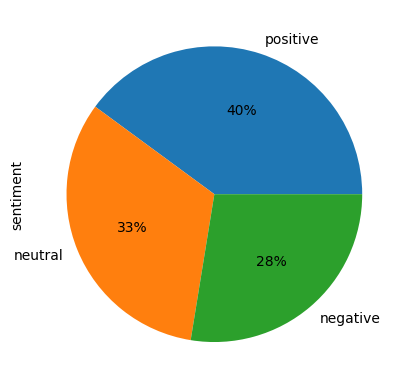

In [14]:
df_sentiment['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

So, the most of labelled tweets are positive tweets!

### **Train model**
We need to divide our data into training and testing sets before training our algorithms.
The training set will be used to train the algorithm, and the test set will be used to evaluate the performance of the machine learning model.

In [15]:
tweets = df_sentiment['text'].values
labels = df_sentiment['sentiment'].values

In the tweets, you can find a lot of slang terms and punctuation marks. Before we can train a machine learning model, we need to clean up our tweets.

In [16]:
processed_tweets = []
for sentence in range(len(tweets)):
  processed_tweet = re.sub(r'http\S+', '', str(tweets[sentence]))
  processed_tweet = re.sub(r'[^a-zA-Z0-9\s]+', ' ', processed_tweet)
  processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
  processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet)
  processed_tweet = re.sub(r'[^\w]', ' ', processed_tweet)
  processed_tweet = re.sub('\s+', ' ', processed_tweet)
  processed_tweet =  re.sub(r' +', ' ', processed_tweet)
  processed_tweet = processed_tweet.lower()
  processed_tweets.append(processed_tweet)
processed_tweets[:5]

[' amd ryzen 4000 desktop cpus looking great and on track to launch in 2020 madtweets stocks cnbc amd',
 ' 863 69 million in sales expected for spirit aerosystems holdings inc spr this quarter stocks',
 'rt pipstodollars earnings amzn tsla msft aapl amd ba fb luv mmm ge aal ups twtr pfe cbsh pep ma googl gild sbux ual ',
 'how will the future fly for spirit air save blog with stocks amp sports on fb bots amp ai also welcome to blog about salesforce crm tommycoulter4 ',
 'interesting comparison to 2007 09 market of spx stocks above 200 day much of 2008 bear market was under that 50 level marked by red line once it got above 65 level in summer 2009 the smoke cleared not as weak in 2020 but something to watch ']

In [17]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
d = pd.DataFrame(processed_tweets, columns=['text'])
d

,text
0,amd ryzen 4000 desktop cpus looking great and...
1,863 69 million in sales expected for spirit a...
2,rt pipstodollars earnings amzn tsla msft aapl ...
3,how will the future fly for spirit air save bl...
4,interesting comparison to 2007 09 market of sp...
...,...
942,q3 2020 eps estimates for ball co bll increase...
943,unh unitedhealth beats eps consensus reiterat...
944,rt macrocharts breadth expanding last week dis...
945,aapl qqq top may now be in


In [19]:
vader = SentimentIntensityAnalyzer()
scores = d['text'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)
scores_df

,neg,neu,pos,compound
0,0.0,0.806,0.194,0.6249
1,0.0,0.892,0.108,0.1779
2,0.0,1.000,0.000,0.0000
3,0.0,0.752,0.248,0.7845
4,0.0,0.903,0.097,0.4124
...,...,...,...,...
942,0.0,0.840,0.160,0.2732
943,0.0,1.000,0.000,0.0000
944,0.0,0.913,0.087,0.2732
945,0.0,0.769,0.231,0.2023


In [20]:
passed, failed = 0, 0
dff = df_sentiment.join(scores_df, rsuffix='_right')
for row in dff.values:
  if row[2] == 'positive':
    if row[7] > 0.2:
      passed += 1
    else:
      failed += 1
  elif row[2] == 'neutral':
    if -0.2 <= row[7] <= 0.2:
      passed += 1
    else:
      failed += 1
  else:
    if row[7] < -0.2:
      passed += 1
    else:
      failed += 1
print(f"Failed {failed}\nPassed: {passed}\nAccuracy: {passed / (passed + failed)}")

Failed 344
Passed: 603
Accuracy: 0.6367476240760296


So we can't use `SentimentIntensityAnalyzer`

In [21]:
vectorizer = TfidfVectorizer(max_features=300000)
stop_words = stopwords.words('english')
tweets = processed_tweets
processed_tweets = vectorizer.fit_transform(processed_tweets).toarray()

Split our dataset into train and test data

In [22]:
x_train, x_test, y_train, y_test = train_test_split(processed_tweets, labels, test_size=0.1, random_state=0)

Let's try Random Forest algorithm

In [23]:
forest = RandomForestClassifier(n_estimators=200, random_state=0)
forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

Let's try Logistic Regression algorithm

In [24]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

Predictions...

In [25]:
predictions = forest.predict(x_test)
pred = logreg.predict(x_test)

Results for Random Forest

In [26]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[ 4  5 16]
 [ 3 21  8]
 [ 0  9 29]]
              precision    recall  f1-score   support

    negative       0.57      0.16      0.25        25
     neutral       0.60      0.66      0.63        32
    positive       0.55      0.76      0.64        38

    accuracy                           0.57        95
   macro avg       0.57      0.53      0.50        95
weighted avg       0.57      0.57      0.53        95

0.5684210526315789


Better than `SentimentIntensityAnalyzer`

Results for Logistic Regression

In [27]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

[[ 7  3 15]
 [ 2 23  7]
 [ 1  8 29]]
              precision    recall  f1-score   support

    negative       0.70      0.28      0.40        25
     neutral       0.68      0.72      0.70        32
    positive       0.57      0.76      0.65        38

    accuracy                           0.62        95
   macro avg       0.65      0.59      0.58        95
weighted avg       0.64      0.62      0.60        95

0.6210526315789474


Even better than Random Forest!

But it is still not enough for our needs

So we can see that accuracy of Random Forest is 57% and for Logistic Regression is 62%. It is not enough for our needs, so we decided to train Neural Net

That process will take too much time so I saved my model in Google Drive

In [28]:
model = keras.models.load_model('/content/drive/MyDrive/models/model.keras')

In [29]:
df_sents = pd.read_csv('/content/drive/MyDrive/datasets/tweet_sentiment.csv')
df_sents = df_sents.dropna()
df_sents = df_sents.drop_duplicates(subset='cleaned_tweets')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [30]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

In [31]:
# @title Helper functions
# Series should be: 1 - Positive, 0 - Neutral, -1 - Negative
def prepare_dataset(texts, sentiments):
  df_t = pd.DataFrame(texts, columns=['text'])
  df_s = pd.DataFrame(sentiments, columns=['sentiment'])
  df_t['text'] = df_t['text'].str.lower()
  df_t['text'] = df_t['text'].apply(lambda x: re.split(r'https:\/\/.*', str(x))[0])
  df_t['text'] = df_t['text'].str.replace(r'\$[A-Za-z0-9\.]+', ' ', regex=True)
  df_t['text'] = df_t['text'].apply(lambda x: re.split(r'(\s)?\$\w+', str(x))[0])
  df_t['text'] = df_t['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
  df_t['text'] = df_t['text'].apply(word_tokenize)
  df_t['text'] = df_t['text'].apply(lambda x: [word for word in x if word not in stop_words])
  df_t['text'] = df_t['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
  encoder = LabelEncoder()
  encoder.fit(df_s['sentiment'])
  Y = encoder.transform(df_s['sentiment'])
  Y = to_categorical(Y)

  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(df_t['text'].values)
  word_index = tokenizer.word_index

  X = tokenizer.texts_to_sequences(df_t['text'].values)
  X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  return X, Y

def prepare_text(texts):
  df_t = pd.DataFrame(texts, columns=['text'])
  df_t['text'] = df_t['text'].str.lower()
  df_t['text'] = df_t['text'].apply(lambda x: re.split(r'https:\/\/.*', str(x))[0])
  df_t['text'] = df_t['text'].str.replace(r'\$[A-Za-z0-9\.]+', ' ', regex=True)
  df_t['text'] = df_t['text'].apply(lambda x: re.split(r'(\s)?\$\w+', str(x))[0])
  df_t['text'] = df_t['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
  df_t['text'] = df_t['text'].apply(word_tokenize)
  df_t['text'] = df_t['text'].apply(lambda x: [word for word in x if word not in stop_words])
  df_t['text'] = df_t['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(df_t['text'].values)
  word_index = tokenizer.word_index

  X = tokenizer.texts_to_sequences(df_t['text'].values)
  X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  return X

def decode_answers(results):
  lst = []
  for result in results:
    pos = result.argmax()
    lst.append(-1 if pos == 0 else (0 if pos == 1 else 1))
  return pd.Series(lst, name='sentiments')

In [32]:
X, Y = prepare_dataset(df_sents['cleaned_tweets'].values, df_sents['sentiment'].values)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [34]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 5,117,635
Trainable params: 5,117,635
Non-trainable params: 0
_________________________________________________________________


After lots of attempts we decided to use 7 epochs

In [35]:
epochs = 7
batch_size = 128

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/7
124/124 [==============================] - 84s 666ms/step - loss: 0.6424 - acc: 0.7333 - val_loss: 0.3228 - val_acc: 0.8864
Epoch 2/7
124/124 [==============================] - 81s 655ms/step - loss: 0.1737 - acc: 0.9451 - val_loss: 0.1842 - val_acc: 0.9415
Epoch 3/7
124/124 [==============================] - 82s 663ms/step - loss: 0.0640 - acc: 0.9804 - val_loss: 0.1807 - val_acc: 0.9415
Epoch 4/7
124/124 [==============================] - 81s 655ms/step - loss: 0.0805 - acc: 0.9766 - val_loss: 0.1846 - val_acc: 0.9420
Epoch 5/7
124/124 [==============================] - 81s 655ms/step - loss: 0.0289 - acc: 0.9908 - val_loss: 0.1942 - val_acc: 0.9477
Epoch 6/7
124/124 [==============================] - 81s 650ms/step - loss: 0.0140 - acc: 0.9963 - val_loss: 0.1905 - val_acc: 0.9523
Epoch 7/7
124/124 [==============================] - 86s 690ms/step - loss: 0.0089 - acc: 0.9980 - val_loss: 0.2018 - val_acc: 0.9557


In [36]:
score = model.evaluate(x_test, y_test, verbose=1)

138/138 [==============================] - 11s 83ms/step - loss: 0.2153 - acc: 0.9559


In [37]:
print("Test Accuracy:", score[1])

Test Accuracy: 0.9558990597724915


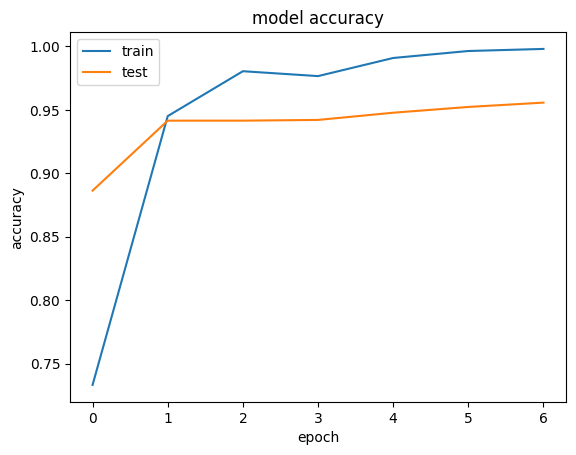

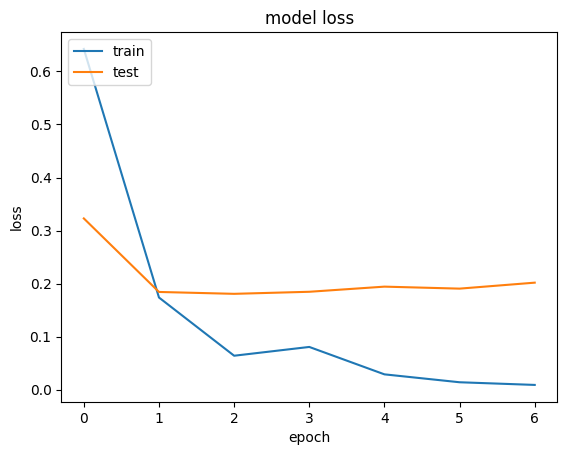

In [38]:
# @title Plotting training results
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Saving model to Google Drive

In [39]:
model.save('/content/drive/MyDrive/models/model.keras')

In [40]:
clear_session()

### **Tickers from datasets**
Let's take first 50 tickers from dataset which appears more than 100 times in our dataset

In [41]:
tickers_to_check = list(set([item for sublist in df_remaining['tickers'].values for item in sublist]))

In [42]:
# Please wait for it
tickers_list = []
amount_list = []
for ticker in tickers_to_check:
  amount = 0
  for row in df_remaining['tickers'].values:
    if ticker in row:
      amount += 1
  if amount >= 100:
    print(f"{ticker} - appeared {amount} times")
    tickers_list.append(ticker)
    amount_list.append(amount)
  if len(tickers_list) >= 50:
    break

$VSLR - appeared 240 times
$REAL - appeared 137 times
$EXC - appeared 207 times
$IQ - appeared 1019 times
$ADA - appeared 105 times
$STAG - appeared 119 times
$BRKA - appeared 355 times
$RVP - appeared 117 times
$SPY - appeared 108936 times
$ALPN - appeared 114 times
$TDG - appeared 104 times
$THOR - appeared 119 times
$NEO - appeared 114 times
$WIMI - appeared 410 times
$RTX - appeared 721 times
$SSEC - appeared 149 times
$TRIP - appeared 582 times
$BMI - appeared 105 times
$NXS - appeared 102 times
$F - appeared 7363 times
$GMER - appeared 126 times
$XLRE - appeared 165 times
$APRN - appeared 724 times
$NUE - appeared 224 times
$OMC - appeared 127 times
$G - appeared 249 times
$GBT - appeared 224 times
$APO - appeared 361 times
$DISCA - appeared 436 times
$AMT - appeared 621 times
$TNA - appeared 147 times
$RVIV - appeared 104 times
$INMB - appeared 159 times
$TXN - appeared 1001 times
$WWE - appeared 278 times
$MJ - appeared 208 times
$SIG - appeared 104 times
$WIT - appeared 216 ti

Now we will convert string timestamp to pandas datetime object

In [43]:
df_remaining['created_at'] = pd.to_datetime(df_remaining['created_at'])

In [44]:
def filter_df(s: pd.Series, ticker):
  lst = []
  if isinstance(ticker, list):
    for val in s.values:
      added = False
      for t in ticker:
        if t in val:
          lst.append(True)
          added = True
          break
      if added == False:
        lst.append(False)
  else:
    for val in s.values:
      lst.append(True if ticker in val else False)
  return pd.Series(lst)

In [45]:
# Please wait for it
timestamps = {}
for ticker in tickers_list:
  timestamps_per_stock = set()
  for row in df_remaining[filter_df(df_remaining['tickers'], ticker)].values:
    timestamps_per_stock.add(row[0].date())
  timestamps[ticker] = timestamps_per_stock

In [46]:
vader = SentimentIntensityAnalyzer()
scores = df_labelled['text'].apply(vader.polarity_scores).tolist()

In [47]:
scores_df = pd.DataFrame(scores)
test = df_labelled.join(scores_df, rsuffix='_right').drop(['sentiment'], axis=1)
test[test['compound'] > 0.5]

,created_at,text,tickers,neg,neu,pos,compound
3,2020-06-06 15:06:34+00:00,How will the future fly for Spirit Air $SAVE ?...,"[$SAVE, $FB, $CRM]",0.000,0.836,0.164,0.5719
18,2020-06-25 10:59:18+00:00,DYK that on May 22 2020 $UONE was trading at $...,[$UONE],0.000,0.900,0.100,0.6956
21,2020-06-16 02:45:02+00:00,$qqq We have detected a noticeable rise in the...,[$QQQ],0.000,0.883,0.117,0.5106
39,2020-06-09 07:44:58+00:00,Remember the turn? Now start preparing for the...,"[$TSLA, $SPY, $GILD, $ABBV, $PFE, $TEVA, $TDOC...",0.067,0.767,0.166,0.6124
42,2020-06-29 15:55:20+00:00,$AMZN Amazon to Pay $500M Bonuses to Employees...,[$AMZN],0.084,0.599,0.317,0.5994
...,...,...,...,...,...,...,...
3668,2020-06-08 21:27:16+00:00,RT @SJD10304: Ran-dumb:\n\n$SPX gains 1% or mo...,"[$SPX, $VIX, $SPX]",0.000,0.827,0.173,0.5859
3672,2020-04-17 01:13:32+00:00,$SPY $SPX Wow what a rally! Skew has gone up t...,"[$SPY, $SPX]",0.000,0.905,0.095,0.6239
3697,2020-04-15 10:30:09+00:00,We're still looking for someone else who can b...,"[$ADBE, $SPX]",0.000,0.899,0.101,0.5562
3698,2020-04-18 14:50:42+00:00,Zacks: Analysts Anticipate Ulta Beauty Inc $UL...,[$ULTA],0.000,0.759,0.241,0.5859


Let's get the most popular stocks

Tech: MSFT, TSLA, NVDA, GOOG, BABA

Bank: BAC, JPM, WFC, C, GS

Health: LLY, UNH, JNJ, MRK, PFE

Energy: XOM, CVX, SLB, BP

Retailer: WMT, TGT, NKE, COST

In [48]:
stocks_list = [
  'MSFT', 'TSLA', 'NVDA', 'GOOG', 'BABA',
  'BAC', 'JPM', 'WFC', 'C', 'GS',
  'LLY', 'UNH', 'JNJ', 'MRK', 'PFE',
  'XOM', 'CVX', 'SLB', 'BP',
  'WMT', 'TGT', 'NKE', 'COST',
]

start_date = '2020-04-09'
end_date = '2020-07-16'

In [49]:
prices = yf.download(stocks_list, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  23 of 23 completed


array([[<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>]], dtype=object)

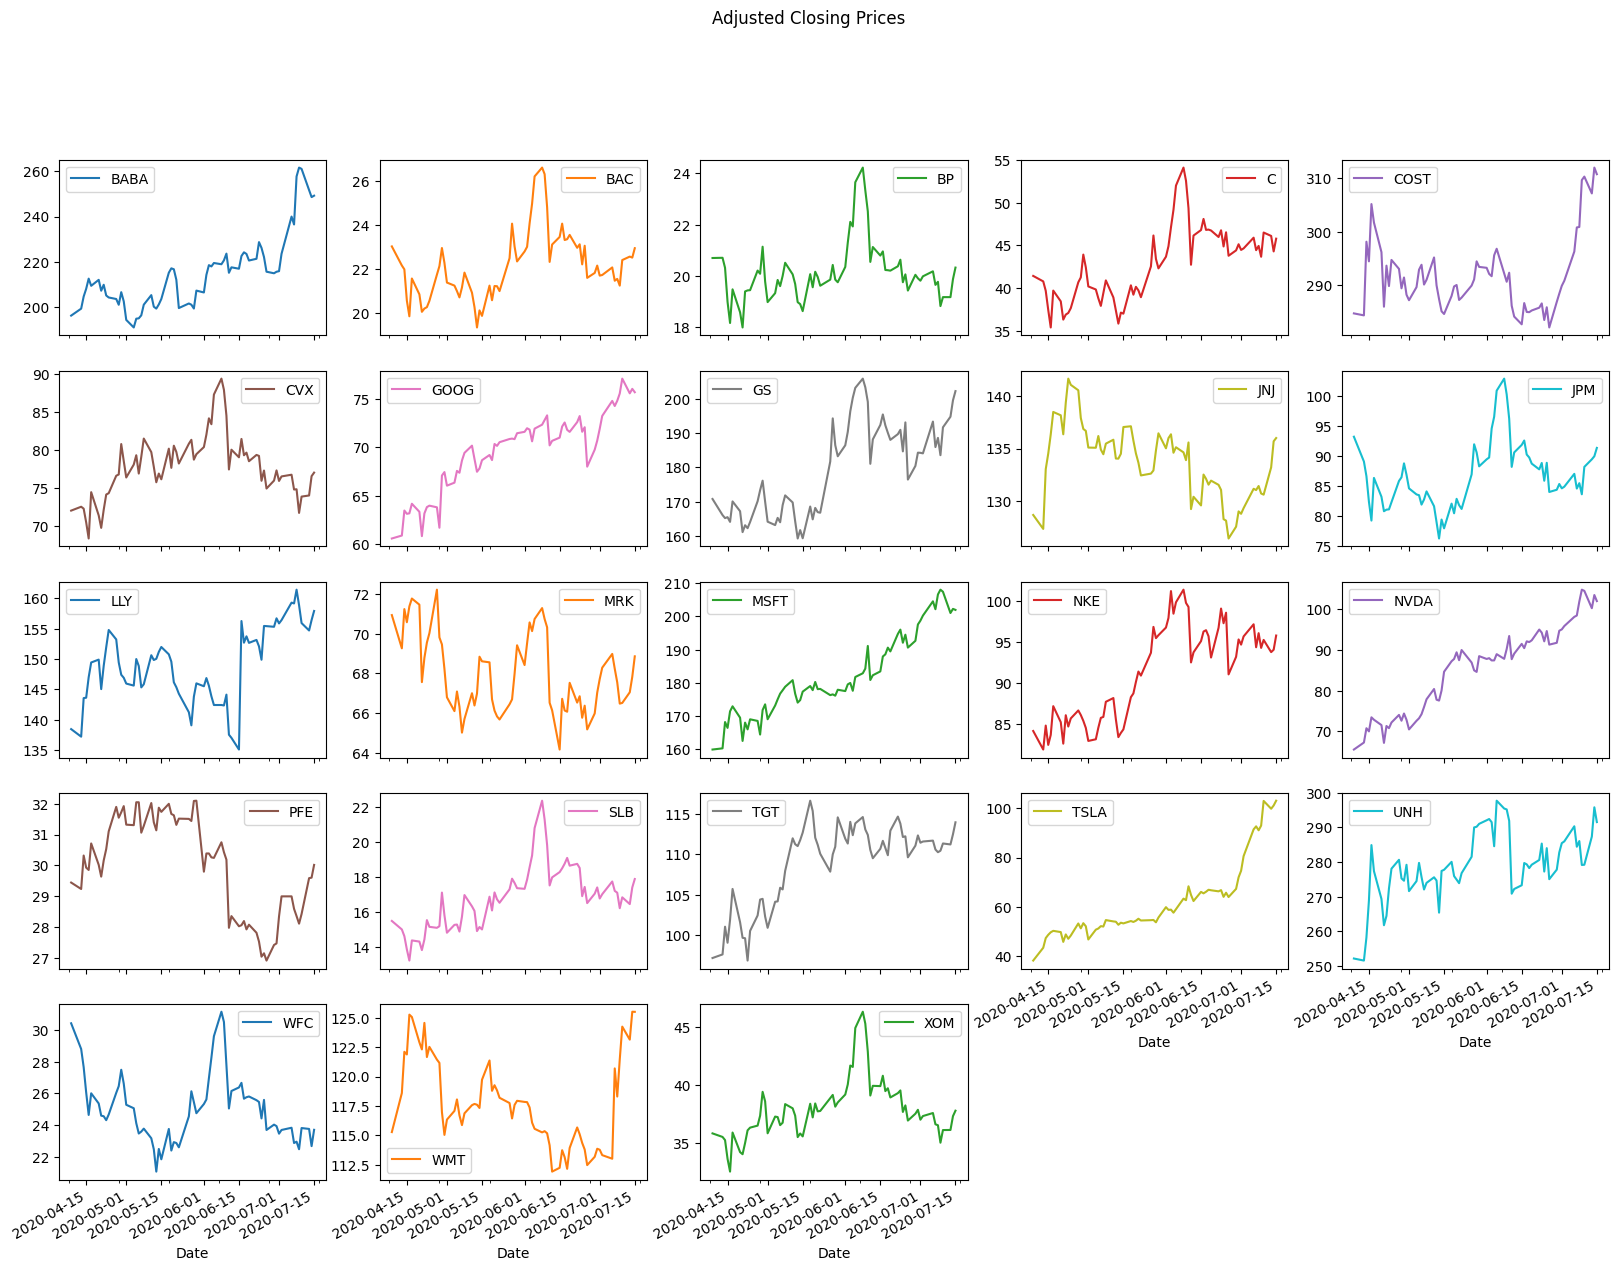

In [50]:
prices.plot(subplots=True, layout=(5,5), figsize=(20, 15), title='Adjusted Closing Prices')

In [51]:
df_remaining['created_at'] = df_remaining['created_at'].dt.normalize()
df_remaining['created_at'] = df_remaining['created_at'].dt.floor('D')
df_remaining['created_at'] = df_remaining['created_at'].dt.date

In [52]:
X_list = []
for x in stocks_list:
  X_list.append(prepare_text(df_remaining[filter_df(df_remaining['tickers'], '$' + x)]['full_text'].values))

In [54]:
predictions = []
for x in X_list:
  predictions.append(model.predict(x))

159/159 [==============================] - 13s 81ms/step


In [55]:
sentiments = []
for pred in predictions:
  sentiments.append(decode_answers(pred))

In [ ]:
sentiments

In [61]:
dfs_tickers = []
for idx in range(len(stocks_list)):
  dfs_tickers.append(df_remaining[filter_df(df_remaining['tickers'], '$' + stocks_list[idx])].reset_index().drop(['index'], axis=1).join(sentiments[idx]))

<ipython-input-139-556ca723e4ea>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_plot = dfs_tickers[idx][filter_df(dfs_tickers[idx]['tickers'], '$' + stocks_list[idx])].groupby(['created_at']).mean()
<ipython-input-139-556ca723e4ea>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_plot = dfs_tickers[idx][filter_df(dfs_tickers[idx]['tickers'], '$' + stocks_list[idx])].groupby(['created_at']).mean()
<ipython-input-139-556ca723e4ea>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_o

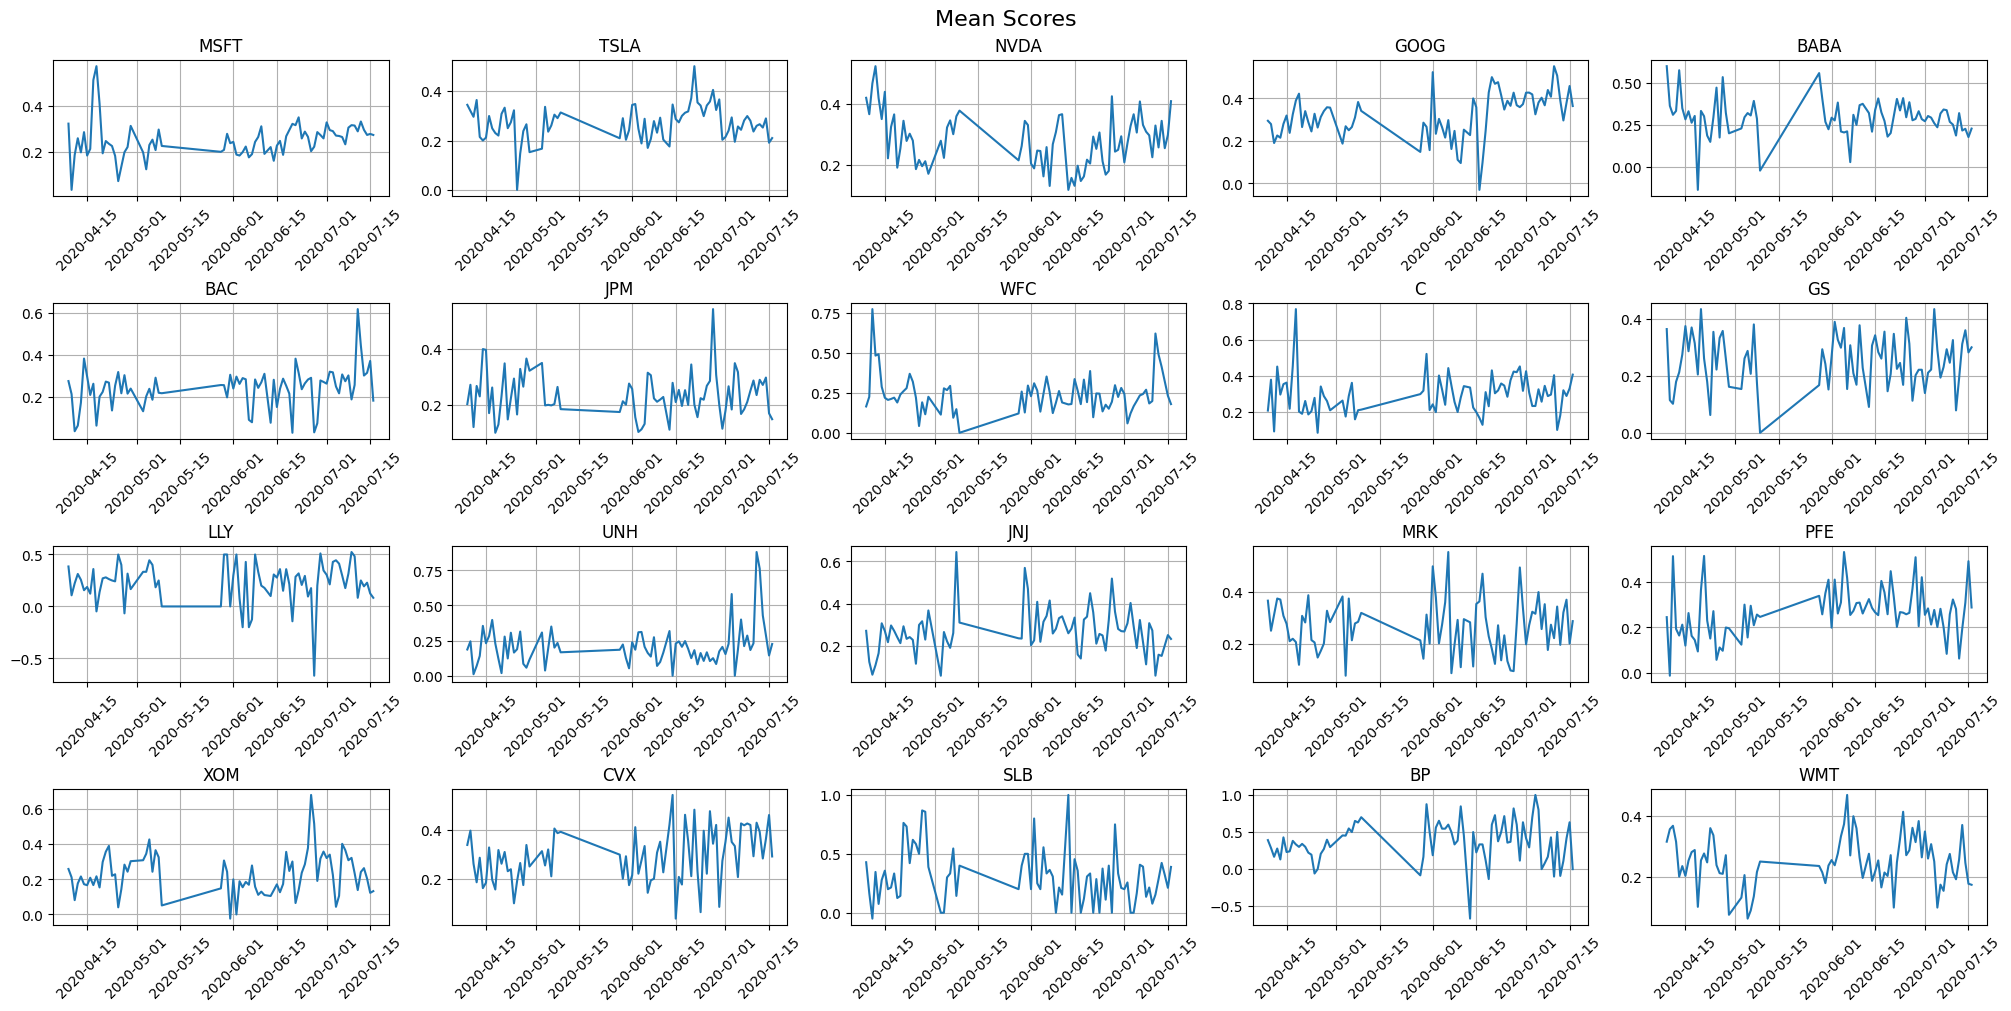

In [139]:
figure, axis = plt.subplots(4, 5, figsize=(20, 10), constrained_layout=True)
idx = 0
figure.suptitle('Mean Scores', fontsize=16)
w = 0.3
mean_scores = []
for x in range(4):
  for y in range(5):
    to_plot = dfs_tickers[idx][filter_df(dfs_tickers[idx]['tickers'], '$' + stocks_list[idx])].groupby(['created_at']).mean()
    mean_scores.append(to_plot)
    axis[x, y].plot(to_plot)
    axis[x, y].tick_params(axis='x', rotation=45)
    axis[x, y].grid()
    axis[x, y].set_title(stocks_list[idx])
    idx += 1
plt.show()

In [86]:
prices

,BABA,BAC,BP,C,COST,CVX,GOOG,GS,JNJ,JPM,...,NKE,NVDA,PFE,SLB,TGT,TSLA,UNH,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-09,196.369995,23.026751,20.697449,41.435432,284.754730,71.982292,60.572498,170.797821,128.661087,93.276108,...,84.138611,65.531952,29.448425,15.484912,97.111305,38.200001,252.169250,30.418766,115.288177,35.823051
2020-04-13,199.440002,22.156069,20.705761,40.797421,284.384583,72.494553,60.877998,166.088959,127.331062,89.127861,...,81.879799,67.251564,29.240395,14.996015,97.558662,43.396667,251.577316,28.797041,118.601074,35.515739
2020-04-14,204.779999,21.980080,20.315086,39.696213,298.166229,72.238434,63.461498,165.208389,133.033936,86.686127,...,84.797852,70.765541,30.322136,14.610536,101.006958,47.326000,258.250824,27.651754,122.103249,35.241650
2020-04-15,208.169998,20.553646,18.985130,37.458820,294.492981,70.428383,63.123501,165.477203,134.518875,82.410843,...,82.442078,69.990463,29.931046,13.848983,99.012527,48.655334,268.924500,26.057522,121.876060,33.622009
2020-04-16,212.660004,19.840425,18.162220,35.413700,305.208954,68.293968,63.173500,164.105331,136.349960,79.270172,...,83.663582,73.444626,29.856157,13.209654,101.864380,49.680668,284.915985,24.637363,125.255211,32.517338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09,261.579987,21.237963,18.821291,43.677067,309.692535,71.678925,75.549500,183.589951,130.708847,83.663002,...,94.261566,104.809196,28.119917,16.215416,110.461617,92.952003,279.172424,22.473661,121.451981,35.019009
2020-07-10,261.010010,22.403862,19.171257,46.503490,310.348877,73.836075,77.086998,191.732712,130.598740,88.236588,...,95.233421,104.512512,28.430874,16.840178,111.361046,102.976669,279.239563,23.810484,124.237534,36.111244
2020-07-13,251.669998,22.562424,19.171257,46.106033,307.200073,73.983337,75.567001,194.829376,133.203934,89.501434,...,93.746468,100.253906,29.590626,16.452068,111.239250,99.804001,287.370422,23.754395,123.134735,36.119701


In [140]:
for idx in range(len(mean_scores)):
  mean_scores[idx].index = pd.to_datetime(mean_scores[idx].index)

In [141]:
prices['MSFT'].index, mean_scores[0].index

(DatetimeIndex(['2020-04-09', '2020-04-13', '2020-04-14', '2020-04-15',
                '2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
                '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
                '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
                '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
                '2020-05-08', '2020-05-11', '2020-05-12', '2020-05-13',
                '2020-05-14', '2020-05-15', '2020-05-18', '2020-05-19',
                '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-26',
                '2020-05-27', '2020-05-28', '2020-05-29', '2020-06-01',
                '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
                '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11',
                '2020-06-12', '2020-06-15', '2020-06-16', '2020-06-17',
                '2020-06-18', '2020-06-19', '2020-06-22', '2020-06-23',
                '2020-06-24', '2020-06-25', '2020-06-26', '2020-

In [148]:
len(mean_scores[0])

77

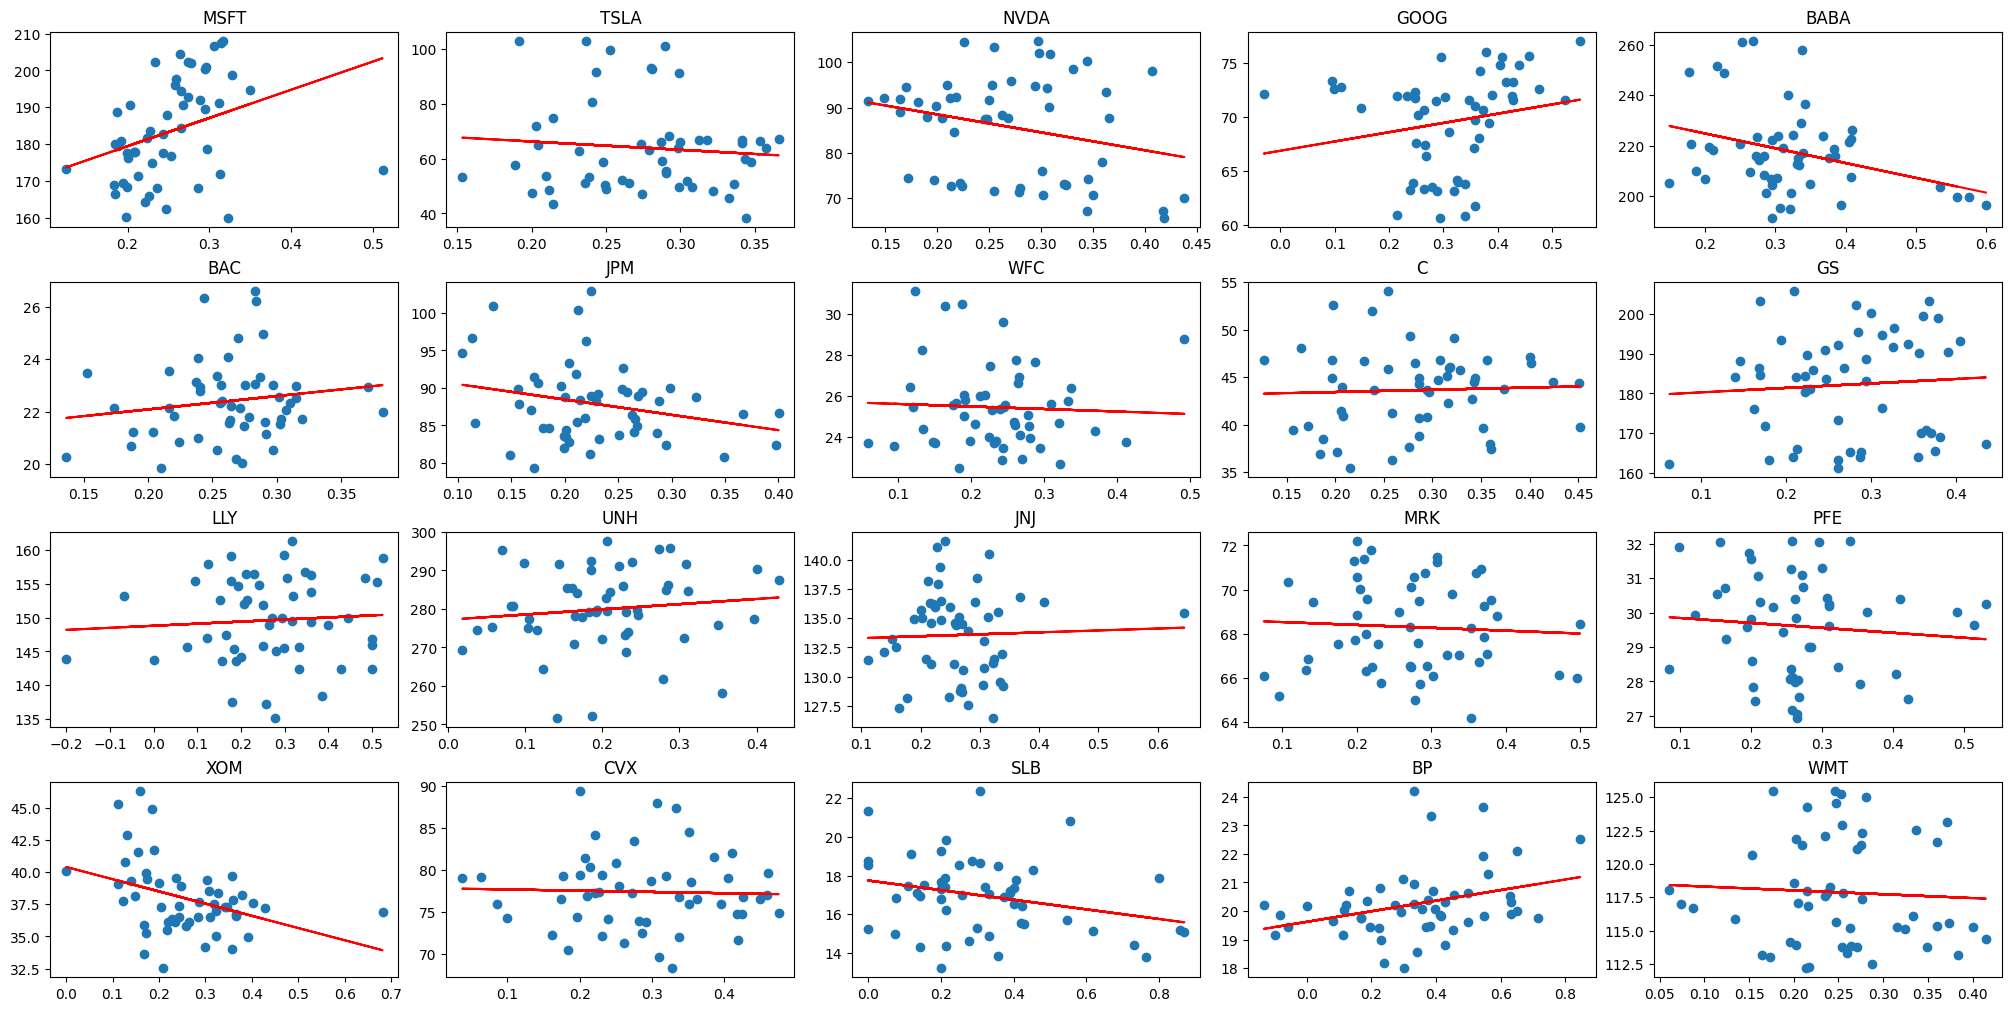

In [161]:
figure, axis = plt.subplots(4, 5, figsize=(20, 10), constrained_layout=True)
idx = 0
for x in range(4):
  for y in range(5):
    idx_ms = set(mean_scores[idx].index)
    idx_pr = set(prices[stocks_list[idx]].index)
    to_drop = list(idx_ms ^ idx_pr)
    for idx1 in range(len(to_drop)):
      to_drop[idx1] = to_drop[idx1].strftime('%Y-%m-%d')
    mrr = mean_scores[idx].drop(to_drop, errors='ignore')
    prr = prices[stocks_list[idx]].drop(to_drop, errors='ignore')
    axis[x, y].scatter(mrr.values, prr.values)
    axis[x, y].set_title(stocks_list[idx])
    X = np.array(mrr.values)
    Y = np.array(prr.values)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    axis[x, y].plot(X, Y_pred, color='red')
    idx += 1
plt.show()